In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [ ]:
X

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...
541904,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
import numpy as np
import pandas as pd

data = X.copy()

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Remove missing customer IDs
data = data[~data['CustomerID'].isna()]

# Remove negative quantity (returns/cancellations)
data = data[data['Quantity'] > 0]

# Remove negative or zero prices
data = data[data['UnitPrice'] > 0]

# Create Revenue column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
# Convert to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Today's reference date = max date in dataset
ref_date = data['InvoiceDate'].max()

# Group by CustomerID
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'Quantity': 'count',                                  # Frequency (proxy)
    'TotalPrice': 'sum'                                   # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [ ]:
import numpy as np
import pandas as pd

# Start from your dataframe X
data = X.copy()

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Remove missing CustomerID
data = data[~data['CustomerID'].isna()]

# Remove negative or zero quantity
data = data[data['Quantity'] > 0]

# Remove negative or zero prices
data = data[data['UnitPrice'] > 0]

# Create TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Reference date = max invoice date
ref_date = data['InvoiceDate'].max()

# Build RFM table (correct for your dataset)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'Quantity': 'count',                                  # Frequency
    'TotalPrice': 'sum'                                   # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [ ]:
import numpy as np

rfm_log = rfm.copy()

# Add +1 to avoid log(0)
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

rfm_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.786897,0.693147,11.253955
12347.0,0.693147,5.209486,8.368925
12348.0,4.317488,3.465736,7.494564
12349.0,2.944439,4.304065,7.472245
12350.0,5.736572,2.890372,5.815324


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled[:5]

array([[ 1.40989446, -2.4343873 ,  3.70622476],
       [-2.14649825,  1.17748295,  1.41184341],
       [ 0.38397128, -0.21705358,  0.7164889 ],
       [-0.57467446,  0.45338686,  0.6987394 ],
       [ 1.37475812, -0.6771919 , -0.6189622 ]])

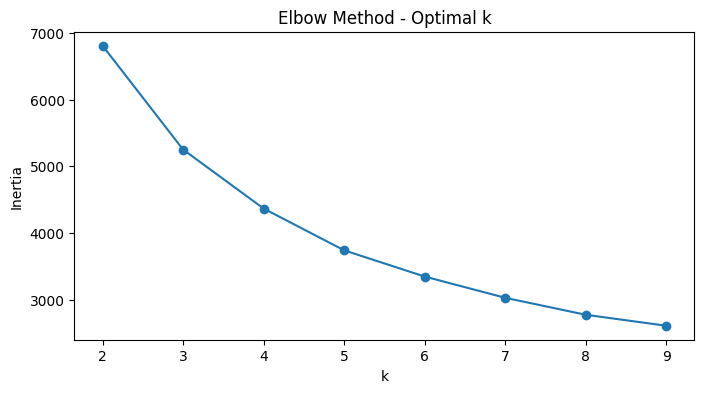

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method - Optimal k')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"k={k} → silhouette={score:.4f}")

k=2 → silhouette=0.3998
k=3 → silhouette=0.3056
k=4 → silhouette=0.3071
k=5 → silhouette=0.2763
k=6 → silhouette=0.2716
k=7 → silhouette=0.2634
k=8 → silhouette=0.2624
k=9 → silhouette=0.2540


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,2
12348.0,74,31,1797.24,1
12349.0,18,73,1757.55,1
12350.0,309,17,334.40,3


In [ ]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster':'NumCustomers'})

cluster_profile

,Recency,Frequency,Monetary,NumCustomers
Cluster,,,,
0,18.436740,37.817518,597.565085,822
1,90.346481,82.204176,1537.402678,1293
2,11.084746,289.792978,7279.545109,826
3,183.218325,15.131711,300.245870,1397


In [ ]:
segment_map = {
    0: 'VIP Customers',
    1: 'Regular Buyers',
    2: 'At-Risk / Dormant',
    3: 'New Customers'
}

rfm['Segment'] = rfm['Cluster'].map(segment_map)

rfm.head()

,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346.0,325,1,77183.60,1,Regular Buyers
12347.0,1,182,4310.00,2,At-Risk / Dormant
12348.0,74,31,1797.24,1,Regular Buyers
12349.0,18,73,1757.55,1,Regular Buyers
12350.0,309,17,334.40,3,New Customers


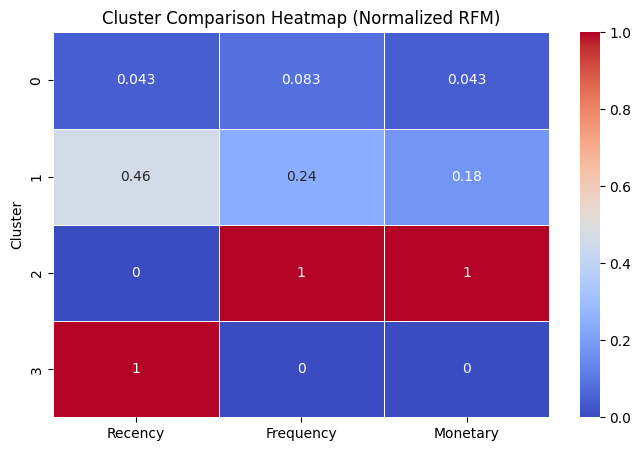

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute cluster averages
cluster_avg = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

# Normalize for visualization
cluster_norm = cluster_avg.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(8, 5))
sns.heatmap(cluster_norm, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Cluster Comparison Heatmap (Normalized RFM)")
plt.show()

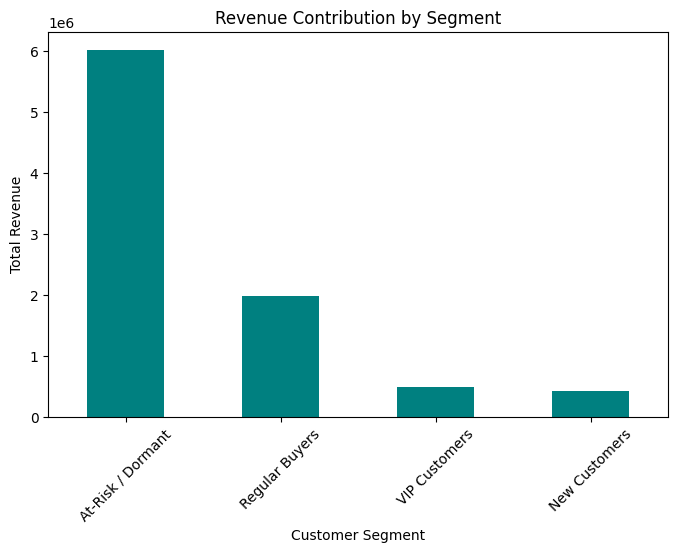

,Monetary
Segment,
At-Risk / Dormant,6012904.260
Regular Buyers,1987861.663
VIP Customers,491198.500
New Customers,419443.481


In [ ]:
# Add revenue per customer (Monetary is already total spent)
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
segment_revenue.plot(kind='bar', color='teal')
plt.title("Revenue Contribution by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()

segment_revenue

In [ ]:
import pandas as pd

business_strategy = pd.DataFrame({
    'Segment': ['VIP Customers', 'Regular Buyers', 'New Customers', 'At-Risk / Dormant'],
    'Behavior Summary': [
        'High spenders, frequent buyers, recent activity',
        'Buy regularly but spend moderately',
        'Recent customers with few purchases',
        'Haven’t purchased recently, low engagement'
    ],
    'Recommended Actions': [
        'Loyalty rewards, exclusive offers, early access products',
        'Upsell bundles, personalized product recommendations',
        'Welcome discounts, onboarding emails, targeted ads',
        'Win-back campaigns, limited-time incentives, reactivation emails'
    ],
    'Goal': [
        'Increase Lifetime Value (LTV)',
        'Increase frequency & average order value',
        'Convert into regular repeat buyers',
        'Reduce churn & recover revenue'
    ]
})

business_strategy

,Segment,Behavior Summary,Recommended Actions,Goal
0,VIP Customers,"High spenders, frequent buyers, recent activity","Loyalty rewards, exclusive offers, early acces...",Increase Lifetime Value (LTV)
1,Regular Buyers,Buy regularly but spend moderately,"Upsell bundles, personalized product recommend...",Increase frequency & average order value
2,New Customers,Recent customers with few purchases,"Welcome discounts, onboarding emails, targeted...",Convert into regular repeat buyers
3,At-Risk / Dormant,"Haven’t purchased recently, low engagement","Win-back campaigns, limited-time incentives, r...",Reduce churn & recover revenue


In [ ]:
segment_map = {
    0: 'VIP Customers',
    1: 'Regular Buyers',
    2: 'At-Risk / Dormant',
    3: 'New Customers'
}

In [ ]:
rfm_strategy = rfm.merge(business_strategy, on='Segment', how='left')
rfm_strategy.head()

,Recency,Frequency,Monetary,Cluster,Segment,Behavior Summary,Recommended Actions,Goal
0,325,1,77183.60,1,Regular Buyers,Buy regularly but spend moderately,"Upsell bundles, personalized product recommend...",Increase frequency & average order value
1,1,182,4310.00,2,At-Risk / Dormant,"Haven’t purchased recently, low engagement","Win-back campaigns, limited-time incentives, r...",Reduce churn & recover revenue
2,74,31,1797.24,1,Regular Buyers,Buy regularly but spend moderately,"Upsell bundles, personalized product recommend...",Increase frequency & average order value
3,18,73,1757.55,1,Regular Buyers,Buy regularly but spend moderately,"Upsell bundles, personalized product recommend...",Increase frequency & average order value
4,309,17,334.40,3,New Customers,Recent customers with few purchases,"Welcome discounts, onboarding emails, targeted...",Convert into regular repeat buyers


In [ ]:
rfm_strategy.to_csv("customer_segments_with_strategy.csv")

In [ ]:
rfm.head()

,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346.0,325,1,77183.60,1,Regular Buyers
12347.0,1,182,4310.00,2,At-Risk / Dormant
12348.0,74,31,1797.24,1,Regular Buyers
12349.0,18,73,1757.55,1,Regular Buyers
12350.0,309,17,334.40,3,New Customers


In [ ]:
rfm.head()

,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346.0,325,1,77183.60,1,Regular Buyers
12347.0,1,182,4310.00,2,At-Risk / Dormant
12348.0,74,31,1797.24,1,Regular Buyers
12349.0,18,73,1757.55,1,Regular Buyers
12350.0,309,17,334.40,3,New Customers


In [ ]:
rfm.to_csv("rfm_final.csv")